In [18]:
import torch
from torch import nn
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import ipywidgets

In [19]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [20]:
def accuracy(y_hat, y):
    
    if len(y_hat) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [21]:
def evaluate_accuracy(net,data_iter):
    with torch.no_grad():
        metric = Accumulator(2)
        for X,y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
        return metric[0] / metric[1]

In [22]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 4070 Ti SUPER', major=8, minor=9, total_memory=16375MB, multi_processor_count=66, uuid=d51c197f-35e3-4bf7-4a2c-d9ca3afb07cb, L2_cache_size=48MB)

In [23]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="./data",train=True,transform=trans,download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="./data",train=False,transform=trans,download=True)

In [24]:
batch_size = 256

train_iter = data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=4)
test_iter = data.DataLoader(mnist_test,batch_size,shuffle=True,num_workers=4)

In [25]:
num_inputs = 784
num_outputs = 10
num_hiddens = 256

W1 = nn.Parameter(torch.randn(num_inputs,num_hiddens,requires_grad=True))
b1 = nn.Parameter(torch.zeros(num_hiddens,requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens,num_outputs,requires_grad=True))
b2 = nn.Parameter(torch.zeros(num_outputs,requires_grad=True))

params = [W1,b1,W2,b2]

In [26]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X,a)

In [27]:
def net(X):
    X=X.reshape((-1,num_inputs))
    H=relu(X @ W1 + b1)
    return (H @ W2 + b2)

loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(params,lr = 0.1)

In [28]:
train_metrics = []

def train(net, train_iter, loss, num_epoches, updater):
    progress_bar = ipywidgets.IntProgress(value=0,min=0,max=(num_epoches-1))
    display(progress_bar)
    for epoch in range(num_epoches):
        metric = Accumulator(3)
        for X,y in train_iter:
            y_hat = net(X)
            # 因为loss function nn.CrossEntropyLoss的特性，这里输入的y表示的是预测的index，loss function会自动完成LogSoftmax操作。
            # 自动LogSoftmax仅在输入的y为Long型tensor时成立，如果输入的是和y_hat形状一致的概率形式，需要对输入手动进行softmax。
            l = loss(y_hat,y)
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l)*len(y),accuracy(y_hat,y),y.size().numel())
        test_accuracy = evaluate_accuracy(net,test_iter)
        train_metrics.append((epoch,metric[0]/metric[2],metric[1]/metric[2],test_accuracy))
        progress_bar.value = epoch

    for item in train_metrics[-3:-1]:
        print(f"Epoch: {item[0]}, train_loss: {item[1]}, train_accuracy: {item[2]}, test_accuracy: {item[3]}")


In [29]:
train(net,train_iter,loss,30,trainer)

IntProgress(value=0, max=29)

Epoch: 27, train_loss: 0.507443230009079, train_accuracy: 0.831, test_accuracy: 0.7953
Epoch: 28, train_loss: 0.5024435222148895, train_accuracy: 0.83325, test_accuracy: 0.8002


(0.0, 2.0)

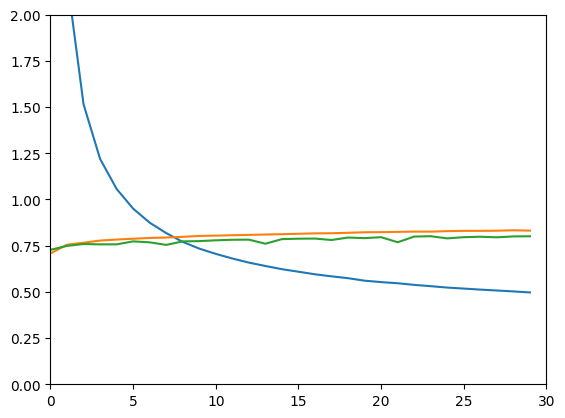

In [30]:
fig, ax = plt.subplots()
ax.plot(range(len(train_metrics)),[i[1] for i in train_metrics])
ax.plot(range(len(train_metrics)),[i[2] for i in train_metrics])
ax.plot(range(len(train_metrics)),[i[3] for i in train_metrics])
ax.set_xlim(0,len(train_metrics))
ax.set_ylim(0,2.0)


Text(0.5, 1.0, 'Real Group: 2, Calculated Group: 6')

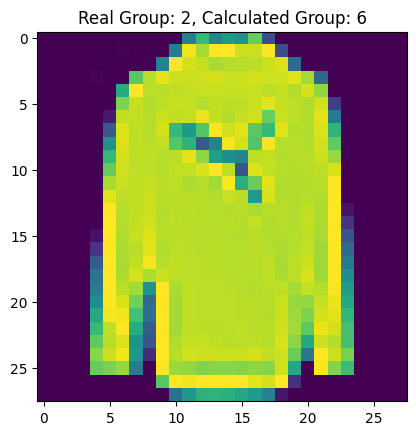

In [31]:
test_item = random.choice(mnist_test)
result = net(test_item[0])
fig, ax = plt.subplots()
ax.imshow(test_item[0].reshape((28,28)))
ax.set_title(f"Real Group: {test_item[1]}, Calculated Group: {result.argmax()}")